In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from scipy import interpolate

In [2]:
#let's consider the atmoshperic parameters for our target:
# (random values...) we should change them according to our values
star_teff = [6350., 50]
star_logg = [4.25, 0.04] 
star_gfeh = [0.00, 0.05] 

# Claret 2017 - fixed stellar metallicity

In [16]:
#!form=a
#${logg} ${Teff} ${Z} ${xi} ${aLSM} ${bLSM} ${aPCM} ${bPCM} ${chi2} ${Mod}
# (hit Return)
## (from tabmap V6.0 (2016-08-18)) 2020-12-08T20:14:03
#---------------------------------------------------------------------------
#-- J/A+A/600/A30 Limb-darkening for TESS satellite (Claret, 2017)
#--------------------------------------------------------------------------
#---Table: J/A+A/600/A30/table25.dat.gz a, b quadratic LDCs, ATLAS models, all metallicities, v.tu=0,1,2,4,8 km/s for TESS (LSM, PCM)  (9586 records)
#-------------------------------------------------------------------------------
#     Label Format Unit    Explanations
#-------------------------------------------------------------------------------
#      logg F5.2   [cm/s2] [0.0/5.0] Surface gravity
#      Teff F6.0   K       [3500/50000] Effective temperature
#         Z F4.1   [Sun]   [-5.0/1.0] Metallicity (log[M/H])
#        xi F3.1   km/s    [0/8] Microturbulent velocity {xi}
#      aLSM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS LSM) (G2)
#      bLSM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS LSM) (G2)
#      aPCM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS FCM) (G2)
#      bPCM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS FCM) (G2)
#      chi2 F6.4   ---     SQRT(CHI2Q) (TESS LSM)
#       Mod A2     ---     [PD PC A] Model name (G3)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------

table25 = np.genfromtxt('Claret2017_table25.dat',dtype=np.double)

# pick the closest value to stellar metallicity
feh_ind = np.argmin(np.abs(table25[:,2]-star_gfeh[0]))
print('Selected metallicity from the table: ', table25[feh_ind,2])
feh_sel = (table25[:,2] == table25[feh_ind,2]) & (table25[:,3] == 2.0) 
# the last one is a mask vector with a True value where there is the selected met
# we also select microturbulence == 2.0

logg_gfeh = table25[feh_sel,0]
teff_gfeh = table25[feh_sel,1]
lfeh_gfeh = table25[feh_sel,2]
ld_c1_gfeh = table25[feh_sel,4]
ld_c2_gfeh = table25[feh_sel,5]

# let's print a bunch of numbers
print('logg: ',logg_gfeh[:10])
print('Teff: ',teff_gfeh[:10])
print('LD c1:',ld_c1_gfeh[:10])
print('LD c2:',ld_c2_gfeh[:10])

print()
print('logg # values: ',len(logg_gfeh[teff_gfeh==6000.]))
print('teff # values: ',len(teff_gfeh[logg_gfeh==4.0]))
print('array size: ',len(logg_gfeh))
print('{0:.0f} x {1:.0f} = {2:.0f}'.format(len(logg_gfeh[teff_gfeh==6000.]), len(teff_gfeh[logg_gfeh==4.0]), len(logg_gfeh)))

# We have three columns that we have to convert to a 2D grid - x, y ,z 
# Fortunately, the file is well formatted - we have a total of 8 values 
# for log(g) for each of 72 values for temperature

# 2.50  2300.  0.0  2.0   0.3720   0.5002   0.1220   0.1678 PC TESS
# 3.00  2300.  0.0  2.0   0.3825   0.4852   0.0849   0.1785 PC TESS
# 3.50  2300.  0.0  2.0   0.4348   0.4310   0.0663   0.1413 PC TESS
# 4.00  2300.  0.0  2.0   0.4840   0.3958   0.0502   0.1122 PC TESS

print()

# avoid extreme gravities and temperatures
sel_logg = (teff_gfeh==6000) & (logg_gfeh > 3.0)
sel_teff = (logg_gfeh==4.5) & (teff_gfeh < 9500.0)

logg_array_gfeh = logg_gfeh[sel_logg]
print('logg coordinates (array): ',logg_array_gfeh)
teff_array_gfeh = teff_gfeh[sel_teff]
print('Teff coordinates (array): ',teff_array_gfeh)



Selected metallicity from the table:  0.0
[False False False ... False False False]
logg:  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
Teff:  [3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500. 3500.]
LD c1: [0.7094 0.7    0.6869 0.6721 0.6573 0.6432 0.6169 0.5206 0.3934 0.3109]
LD c2: [0.0523 0.0489 0.0492 0.0518 0.0557 0.0612 0.0809 0.1676 0.277  0.3446]

logg # values:  11
teff # values:  65
array size:  476
11 x 65 = 476

logg coordinates (array):  [3.5 4.  4.5 5. ]
Teff coordinates (array):  [3500. 3750. 4000. 4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250.
 6500. 6750. 7000. 7250. 7500. 7750. 8000. 8250. 8500. 8750. 9000. 9250.]


Matrix shape:  (4, 24)


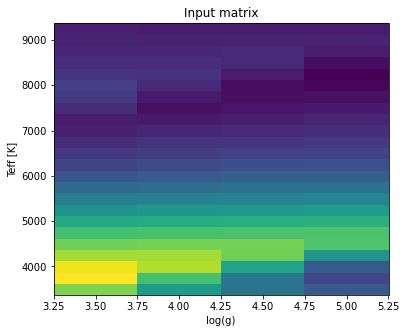

In [4]:
# we create a 2D grid with size (len(logg_array) x len(teff_array))
# for each LD coefficient, so two matrices

c1_matrix_gfeh = np.zeros((len(logg_array_gfeh), len(teff_array_gfeh)))
c2_matrix_gfeh = np.zeros((len(logg_array_gfeh), len(teff_array_gfeh)))
print('Matrix shape: ',np.shape(c1_matrix_gfeh))

for logg_i, logg_v in enumerate(logg_array_gfeh):
    for teff_i, teff_v in enumerate(teff_array_gfeh):
        
        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (logg_gfeh == logg_v) & (teff_gfeh == teff_v)
        
        if np.sum(sel) == 1: # when we perform such a sum, booleans True and False are covnerted into 1 and 0, so the sum is trivial
            c1_matrix_gfeh[logg_i, teff_i] = ld_c1_gfeh[sel]
            c2_matrix_gfeh[logg_i, teff_i] = ld_c2_gfeh[sel]
        else:
            print('No value for (logg,teff)=({0:f},{1:f})'.format(logg_v,teff_v))
            c1_matrix_gfeh[logg_i, teff_i] = (c1_matrix_gfeh[logg_i, teff_i-1] + c1_matrix_gfeh[logg_i, teff_i+1])/2
            c2_matrix_gfeh[logg_i, teff_i] = (c2_matrix_gfeh[logg_i, teff_i-1] + c2_matrix_gfeh[logg_i, teff_i+1])/2
            # replacing this combination with average values


# Let's see the "real" matrix
xx, yy = np.meshgrid(logg_array_gfeh,teff_array_gfeh)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_gfeh.T, shading='auto')
plt.title('Input matrix')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

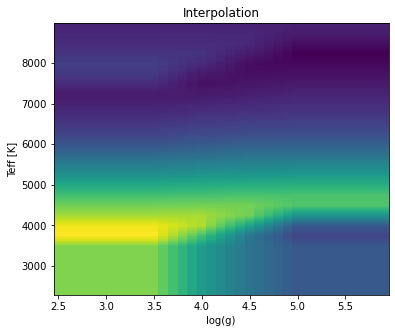

In [5]:
# bilinear_interpolation usci Scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

# Note: if len(logg_array)=m and len(teff_array)=n, the third array must be n*m 
c1_function_gfeh = interpolate.interp2d(logg_array_gfeh, teff_array_gfeh, c1_matrix_gfeh.T, kind='linear')
c2_function_gfeh = interpolate.interp2d(logg_array_gfeh, teff_array_gfeh, c2_matrix_gfeh.T, kind='linear')

teff_grid = np.arange(2300, 9000, 25)
logg_grid = np.arange(2.5, 6.0, 0.1)

xx, yy = np.meshgrid(logg_grid,teff_grid)
c1_plot_out = c1_function_gfeh(logg_grid, teff_grid)

plt.figure(figsize=(6,5))
plt.pcolor(xx,yy, c1_plot_out, shading='auto')
plt.title('Interpolation')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

# Claret 2017 - fixed gravity

In [6]:
#!form=a
#${logg} ${Teff} ${Z} ${xi} ${aLSM} ${bLSM} ${aPCM} ${bPCM} ${chi2} ${Mod}
# (hit Return)
## (from tabmap V6.0 (2016-08-18)) 2020-12-08T20:14:03
#---------------------------------------------------------------------------
#-- J/A+A/600/A30 Limb-darkening for TESS satellite (Claret, 2017)
#--------------------------------------------------------------------------
#---Table: J/A+A/600/A30/table25.dat.gz a, b quadratic LDCs, ATLAS models, all metallicities, v.tu=0,1,2,4,8 km/s for TESS (LSM, PCM)  (9586 records)
#-------------------------------------------------------------------------------
#     Label Format Unit    Explanations
#-------------------------------------------------------------------------------
#      logg F5.2   [cm/s2] [0.0/5.0] Surface gravity
#      Teff F6.0   K       [3500/50000] Effective temperature
#         Z F4.1   [Sun]   [-5.0/1.0] Metallicity (log[M/H])
#        xi F3.1   km/s    [0/8] Microturbulent velocity {xi}
#      aLSM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS LSM) (G2)
#      bLSM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS LSM) (G2)
#      aPCM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS FCM) (G2)
#      bPCM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS FCM) (G2)
#      chi2 F6.4   ---     SQRT(CHI2Q) (TESS LSM)
#       Mod A2     ---     [PD PC A] Model name (G3)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------
#table15 = np.genfromtxt('table15_claret2017.dat',dtype=np.double)

table25 = np.genfromtxt('Claret2017_table25.dat',dtype=np.double)

# pick the closest value to stellar gravity
logg_ind = np.argmin(np.abs(table25[:,0]-star_logg[0]))
print('Selected gravity from the table: ', table25[logg_ind,0])
logg_sel = (table25[:,0] == table25[logg_ind,0]) & (table25[:,3] == 2.0) 
# we also select microturbulence == 2.0

teff_logg = table25[logg_sel,1]
gfeh_logg = table25[logg_sel,2]
ld_c1_logg = table25[logg_sel,4]
ld_c2_logg = table25[logg_sel,5]

# let's print a bunch of numbers
print('gfeh: ',gfeh_logg[:10])
print('Teff: ',teff_logg[:10])
print('LD c1:',ld_c1_logg[:10])
print('LD c2:',ld_c2_logg[:10])

print()
print('gfeh # values: ',len(gfeh_logg[teff_logg==6000.]))
print('teff # values: ',len(teff_logg[gfeh_logg==0.0]))
print('array size: ',len(gfeh_logg))
print('8 x 72 = ', 8*72, ' !!!!')

# We have three columns that we have to convert to a 2D grid - x, y ,z 
# Fortunately, the file is well formatted - we have a total of 8 values 
# for log(g) for each of 72 values for temperature

# 2.50  2300.  0.0  2.0   0.3720   0.5002   0.1220   0.1678 PC TESS
# 3.00  2300.  0.0  2.0   0.3825   0.4852   0.0849   0.1785 PC TESS
# 3.50  2300.  0.0  2.0   0.4348   0.4310   0.0663   0.1413 PC TESS
# 4.00  2300.  0.0  2.0   0.4840   0.3958   0.0502   0.1122 PC TESS

print()

# avoid extreme gravities and temperatures
sel_gfeh = (teff_logg==6000) & (gfeh_logg > -1.5)
sel_teff = (gfeh_logg==0.0) & (teff_logg < 9500.0)

gfeh_array_logg = gfeh_logg[sel_gfeh]
print('logg coordinates (array): ',gfeh_array_logg)
teff_array_logg = teff_logg[sel_teff]
print('Teff coordinates (array): ',teff_array_logg)



Selected gravity from the table:  4.0
gfeh:  [-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
Teff:  [4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250. 6500.]
LD c1: [-0.0065  0.0326  0.1062  0.1722  0.1939  0.1998  0.2111  0.2194  0.2196
  0.2177]
LD c2: [0.4091 0.4183 0.3961 0.3557 0.34   0.33   0.3157 0.3026 0.2957 0.2904]

gfeh # values:  19
teff # values:  65
array size:  1037
8 x 72 =  576  !!!!

logg coordinates (array):  [-1.  -0.5 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.5  1. ]
Teff coordinates (array):  [3500. 3750. 4000. 4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250.
 6500. 6750. 7000. 7250. 7500. 7750. 8000. 8250. 8500. 8750. 9000. 9250.]


Matrix shape:  (11, 24)


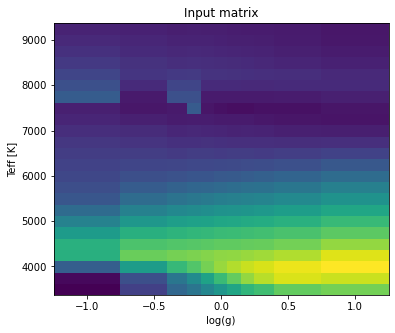

In [7]:
# we create a 2D grid with size (len(gfeh_array) x len(teff_array))
# for each LD coefficient

c1_matrix_logg = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))
c2_matrix_logg = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))
print('Matrix shape: ',np.shape(c1_matrix_logg))

for gfeh_i, gfeh_v in enumerate(gfeh_array_logg):
    for teff_i, teff_v in enumerate(teff_array_logg):
        
        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (gfeh_logg == gfeh_v) & (teff_logg == teff_v)
        
        if np.sum(sel) == 1:
            c1_matrix_logg[gfeh_i, teff_i] = ld_c1_logg[sel]
            c2_matrix_logg[gfeh_i, teff_i] = ld_c2_logg[sel]
        else:
            print('No value for (gfeh,teff)=({0:f},{1:f})'.format(gfeh_v,teff_v))
            print(np.sum(sel))
            c1_matrix_logg[gfeh_i, teff_i] = (c1_matrix_logg[gfeh_i, teff_i-1] + c1_matrix_logg[gfeh_i, teff_i+1])/2
            c2_matrix_logg[gfeh_i, teff_i] = (c2_matrix_logg[gfeh_i, teff_i-1] + c2_matrix_logg[gfeh_i, teff_i+1])/2
            # replacing this combination with average values


# Le't see the "real" matrix
xx, yy = np.meshgrid(gfeh_array_logg,teff_array_logg)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_logg.T, shading='auto')
plt.title('Input matrix')
plt.xlabel('log(g)')
plt.ylabel('Teff [K]')
plt.show()

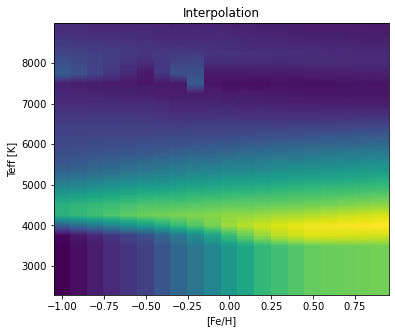

In [8]:
# bilinear_interpolation usci Scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

# Note: if len(gfeh_array)=m and len(teff_array)=n, the third array must be n*m 
c1_function_logg = interpolate.interp2d(gfeh_array_logg, teff_array_logg, c1_matrix_logg.T, kind='linear')
c2_function_logg = interpolate.interp2d(gfeh_array_logg, teff_array_logg, c2_matrix_logg.T, kind='linear')

teff_grid = np.arange(2300, 9000, 25)
gfeh_grid = np.arange(-1.0, 1.0, 0.1)

xx, yy = np.meshgrid(gfeh_grid,teff_grid)
c1_plot_out = c1_function_logg(gfeh_grid, teff_grid)

plt.figure(figsize=(6,5))
plt.pcolor(xx,yy, c1_plot_out, shading='auto')
plt.title('Interpolation')
plt.xlabel('[Fe/H]')
plt.ylabel('Teff [K]')
plt.show()

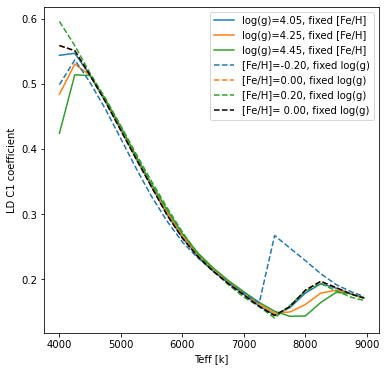

In [9]:
teff_curve = np.arange(4000,9000,50)
c1_logg_m02 = c1_function_gfeh(star_logg[0]-0.2, teff_curve)
c1_logg_val = c1_function_gfeh(star_logg[0]    , teff_curve)
c1_logg_p02 = c1_function_gfeh(star_logg[0]+0.2, teff_curve)

c1_gfeh_m02 = c1_function_logg(star_gfeh[0]-0.2, teff_curve)
c1_gfeh_val = c1_function_logg(star_gfeh[0]    , teff_curve)
c1_gfeh_p02 = c1_function_logg(star_gfeh[0]+0.2, teff_curve)
c1_gfeh_v00 = c1_function_logg(0.000, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c1_logg_m02, c='C0', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]-0.2))
plt.plot(teff_curve, c1_logg_val, c='C1', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]))
plt.plot(teff_curve, c1_logg_p02, c='C2', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]+0.2))
plt.plot(teff_curve, c1_gfeh_m02, c='C0', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]-0.2))
plt.plot(teff_curve, c1_gfeh_val, c='C1', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]))
plt.plot(teff_curve, c1_gfeh_p02, c='C2', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]+0.2))
plt.plot(teff_curve, c1_gfeh_v00, c='k', linestyle='--', label='[Fe/H]= 0.00, fixed log(g)'.format(star_gfeh[0]+0.2))
plt.ylabel('LD C1 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

In [10]:
# main conclusion here is that gravity and metallicity do not influence strongly the limb darkening parameters

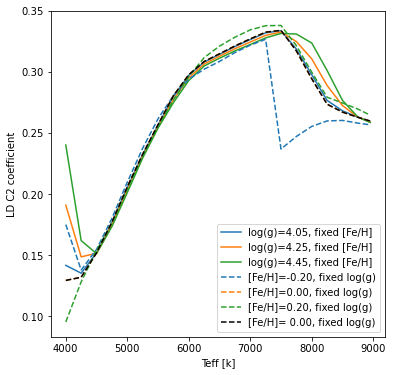

In [11]:
teff_curve = np.arange(4000,9000,50)
c2_logg_m02 = c2_function_gfeh(star_logg[0]-0.2, teff_curve)
c2_logg_val = c2_function_gfeh(star_logg[0]    , teff_curve)
c2_logg_p02 = c2_function_gfeh(star_logg[0]+0.2, teff_curve)

c2_gfeh_m02 = c2_function_logg(star_gfeh[0]-0.2, teff_curve)
c2_gfeh_val = c2_function_logg(star_gfeh[0]    , teff_curve)
c2_gfeh_p02 = c2_function_logg(star_gfeh[0]+0.2, teff_curve)
c2_gfeh_v00 = c2_function_logg(0.000, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c2_logg_m02, c='C0', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]-0.2))
plt.plot(teff_curve, c2_logg_val, c='C1', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]))
plt.plot(teff_curve, c2_logg_p02, c='C2', label='log(g)={0:.2f}, fixed [Fe/H]'.format(star_logg[0]+0.2))
plt.plot(teff_curve, c2_gfeh_m02, c='C0', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]-0.2))
plt.plot(teff_curve, c2_gfeh_val, c='C1', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]))
plt.plot(teff_curve, c2_gfeh_p02, c='C2', linestyle='--', label='[Fe/H]={0:.2f}, fixed log(g)'.format(star_gfeh[0]+0.2))
plt.plot(teff_curve, c2_gfeh_v00, c='k', linestyle='--', label='[Fe/H]= 0.00, fixed log(g)'.format(star_gfeh[0]+0.2))
plt.ylabel('LD C2 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

In [12]:
teff_in = star_teff[0]
logg_in = star_logg[0]
c1_star = c1_function_gfeh(logg_in, teff_in)[0]
c2_star = c2_function_gfeh(logg_in, teff_in)[0]
print('Claret 2017, fixed [Fe/H]: logg={0:.2f}, teff={1:.0f}, c1={2:f} c2={3:f}'.format(logg_in, teff_in, c1_star, c2_star))


teff_in = star_teff[0]
gfeh_in = star_gfeh[0]
c1_star_gfeh = c1_function_logg(gfeh_in, teff_in)[0]
c2_star_gfeh = c2_function_logg(gfeh_in, teff_in)[0]
print('Claret 2017, fixed log(g): gfeh={0:.2f}, teff={1:.0f}, c1={2:f} c2={3:f}'.format(gfeh_in, teff_in, c1_star_gfeh, c2_star_gfeh))

Claret 2017, fixed [Fe/H]: logg=4.25, teff=6350, c1=0.228710 c2=0.309090
Claret 2017, fixed log(g): gfeh=0.00, teff=6350, c1=0.225600 c2=0.311120


In [13]:
# Let'r try again with a lot more of samples
n_sample = 100000  # start small (1000) and increase the number while execution time is still acceptable
teff_dist = np.random.normal(star_teff[0], star_teff[1], n_sample)
logg_dist = np.random.normal(star_logg[0], star_logg[1], n_sample)
gfeh_dist = np.random.normal(star_gfeh[0], star_gfeh[1], n_sample)

# let's do it the slow - but safe - way
c1_dist_logg = np.zeros(n_sample)
c2_dist_logg = np.zeros(n_sample)
c1_dist_gfeh = np.zeros(n_sample)
c2_dist_gfeh = np.zeros(n_sample)
for ii in range(0, n_sample):
    c1_dist_logg[ii] = c1_function_logg(gfeh_dist[ii], teff_dist[ii])
    c2_dist_logg[ii] = c2_function_logg(gfeh_dist[ii], teff_dist[ii])
    c1_dist_gfeh[ii] = c1_function_gfeh(logg_dist[ii], teff_dist[ii])
    c2_dist_gfeh[ii] = c2_function_gfeh(logg_dist[ii], teff_dist[ii])
    

number of samples: 100000   shape of the array: (100000,)



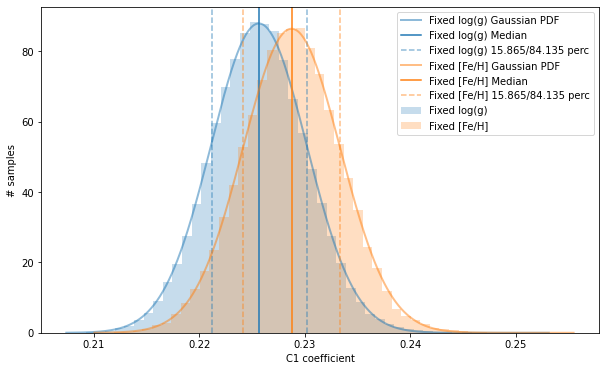

In [14]:
print('number of samples:',len(c1_dist_logg),'  shape of the array:', c1_dist_logg.shape)

print()
c1_gfeh_average = np.average(c1_dist_gfeh) # average
c1_gfeh_median = np.median(c1_dist_gfeh)   # median
c1_gfeh_std = np.std(c1_dist_gfeh)         # standard deviation
c1_gfeh_minus1sigma_perc = np.percentile(c1_dist_gfeh, 15.865)
c1_gfeh_plus1sigma_perc = np.percentile(c1_dist_gfeh, 84.135)

c1_logg_average = np.average(c1_dist_logg) # average
c1_logg_median = np.median(c1_dist_logg)   # median
c1_logg_std = np.std(c1_dist_logg)         # standard deviation
c1_logg_minus1sigma_perc = np.percentile(c1_dist_logg, 15.865)
c1_logg_plus1sigma_perc = np.percentile(c1_dist_logg, 84.135)

# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c1_dist_logg, 50, density=True, label='Fixed log(g)', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c1_logg_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c1_logg_median)**2 / (2 *  c1_logg_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Fixed log(g) Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c1_logg_median,  c='C0', label='Fixed log(g) Median')
plt.axvline(c1_logg_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label='Fixed log(g) 15.865/84.135 perc')
plt.axvline(c1_logg_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')

count, bins, _ = plt.hist(c1_dist_gfeh, 50, density=True, label='Fixed [Fe/H]', alpha=0.25, color='C1')
x_gauss = np.linspace(bins[0], bins[-1], 1000)

y_gauss = 1/( c1_gfeh_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c1_gfeh_median)**2 / (2 *  c1_gfeh_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Fixed [Fe/H] Gaussian PDF',  color='C1', alpha=0.5)

plt.axvline(c1_gfeh_median,  c='C1', label='Fixed [Fe/H] Median')
plt.axvline(c1_gfeh_minus1sigma_perc, alpha=0.5, c='C1', linestyle='--', label='Fixed [Fe/H] 15.865/84.135 perc')
plt.axvline(c1_gfeh_plus1sigma_perc , alpha=0.5, c='C1', linestyle='--')


plt.xlabel('C1 coefficient')
plt.ylabel('# samples')
plt.legend()
plt.show()



number of samples: 100000   shape of the array: (100000,)



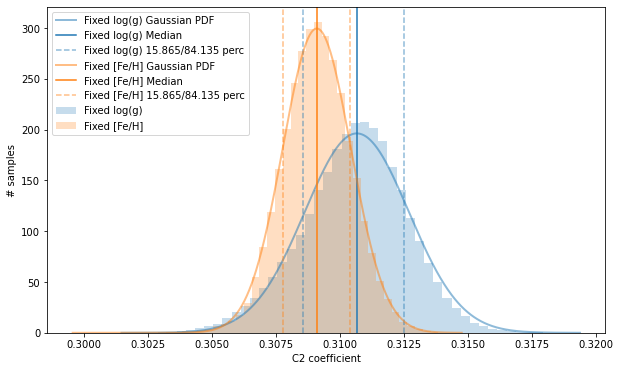

In [15]:
print('number of samples:',len(c2_dist_logg),'  shape of the array:', c2_dist_logg.shape)

print()
c2_gfeh_average = np.average(c2_dist_gfeh) # average
c2_gfeh_median = np.median(c2_dist_gfeh)   # median
c2_gfeh_std = np.std(c2_dist_gfeh)         # standard deviation
c2_gfeh_minus1sigma_perc = np.percentile(c2_dist_gfeh, 15.865)
c2_gfeh_plus1sigma_perc = np.percentile(c2_dist_gfeh, 84.135)

c2_logg_average = np.average(c2_dist_logg) # average
c2_logg_median = np.median(c2_dist_logg)   # median
c2_logg_std = np.std(c2_dist_logg)         # standard deviation
c2_logg_minus1sigma_perc = np.percentile(c2_dist_logg, 15.865)
c2_logg_plus1sigma_perc = np.percentile(c2_dist_logg, 84.135)

# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c2_dist_logg, 50, density=True, label='Fixed log(g)', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c2_logg_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c2_logg_median)**2 / (2 *  c2_logg_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Fixed log(g) Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c2_logg_median,  c='C0', label='Fixed log(g) Median')
plt.axvline(c2_logg_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label='Fixed log(g) 15.865/84.135 perc')
plt.axvline(c2_logg_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')

count, bins, _ = plt.hist(c2_dist_gfeh, 50, density=True, label='Fixed [Fe/H]', alpha=0.25, color='C1')
x_gauss = np.linspace(bins[0], bins[-1], 1000)

y_gauss = 1/( c2_gfeh_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c2_gfeh_median)**2 / (2 *  c2_gfeh_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Fixed [Fe/H] Gaussian PDF',  color='C1', alpha=0.5)

plt.axvline(c2_gfeh_median,  c='C1', label='Fixed [Fe/H] Median')
plt.axvline(c2_gfeh_minus1sigma_perc, alpha=0.5, c='C1', linestyle='--', label='Fixed [Fe/H] 15.865/84.135 perc')
plt.axvline(c2_gfeh_plus1sigma_perc , alpha=0.5, c='C1', linestyle='--')


plt.xlabel('C2 coefficient')
plt.ylabel('# samples')
plt.legend()
plt.show()

